<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 40px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Hero Book
  </div> 
  
  
 <div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Livres dont vous êtes le héros
  </div> 
  


  <div style=" float:left; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  Jean-baptiste AUJOGUE
  </div> 

<a id="TOC"></a>

***
<div style="font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Table of Content
  </div> 


1. [PDF parsing - Text approach](#text_pdf_parsing)

     1.1 [Raw text parsing](#text_parsing)<br>
     1.2 [Episode markers](#text_episode_marker)<br>
     1.3 [Episode text](#text_episode_text)<br>
     1.4 [Hyperlink source and target](#text_hyperlink)<br>
     
     
2. [PDF parsing - Bounding box approach](#box_pdf_parsing)

     2.1 [Bounding box parsing](#box_parsing)<br>
     2.2 [Episode markers](#box_episode_marker)<br>
     2.3 [Episode content](#box_episode_text)<br>
     2.4 [Hyperlink source and target](#box_hyperlink)<br>


3. [Text analysis](#nlp)

     3.1 [Detection of events](#nlp_event)<br>
     3.2 [Detection of found & necessary elements](#nlp_element)<br>


4. [Graph representation](#graph)

     4.1 [Graph construction](#graph_construction)<br>
     4.2 [Graph visualization](#graph_visualization)<br>
     4.3 [Solve the book](#graph_solve)<br>
     

5. [End-to-end process](#end_to_end)

[Bottom](#bottom)
***

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import re
import random
import copy
import itertools

# pdf
import fitz # name of pymupdf

# data 
import numpy as np
import pandas as pd

# graph
import networkx as nx

# nlu
import spacy
import coreferee

# viz
import pyvis.network as nt
import tqdm

print('python version :', sys.version)

python version : 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


#### Path to sub-directories

In [3]:
path_to_repo = os.path.dirname(os.getcwd())
path_to_data = os.path.join(path_to_repo, 'data')
path_to_pdfs = os.path.join(path_to_data, 'pdfs')
path_to_src  = os.path.join(path_to_repo, 'src')

In [4]:
sys.path.insert(0, path_to_src)

In [5]:
from herobook.parsing import parse_pdf_raw_text, parse_pdf_df_text
from herobook.episode import (
    get_episode_dict,
    find_episode_markers_from_lines,
    find_targets_from_text,
)
from herobook.graph import build_nx_graph, build_nt_graph, convert_nx_to_nt_graph

<a id="text_pdf_parsing"></a>

# 1. PDF parsing - Text approach

[Table of content](#TOC)

see the [PyMuPDF docs](https://pymupdf.readthedocs.io/en/latest/textpage.html#structure-of-dictionary-outputs)

In [6]:
fine_name = os.listdir(path_to_pdfs)[1]
file_path = os.path.join(path_to_pdfs, fine_name)
file_path

'C:\\Users\\Jb\\Desktop\\NLP\\Funcode - Hero Book\\data\\pdfs\\Loup Solitaire 01 - Les Maitres des Tenebres.pdf'

<a id="text_parsing"></a>

## 1.1 Raw text parsing

[Table of content](#TOC)


In [7]:
text = parse_pdf_raw_text(file_path)

In [8]:
# see episode 336 on how vanilla approach strugles
print(text)

 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
© Joe Dever, 1984, pour le texte © Gary Chalk, 1984, pour les illustrations © Solar Wind 
Ltd, 1985, pour l'illustration de couverture © Éditions Gallimard, 1985, pour la traduction 
française 
 
 
 
 
Joe Dever 
Les Maîtres des Ténèbres/1 
Illustrations de Gary Chalk 
Traduit de l'anglais par Camille Fabien 
 
 
 
 
 
 
 
 
 
 
 
 
UN LIVRE 
DONT VOUS ÊTES 
LE HÉROS 
GALLIMARD JEUNESSE
 
 
 
 
 
 
 
 
 
 
 
 
 
 
Règles du jeu 
Vous trouverez au début de ce livre une Feuille d'Aventure sur 
laquelle vous inscrirez tous les détails de votre quête. Il est 
conseillé d'en faire des photocopies qui vous permettront de 
jouer plusieurs fois. 
Au cours de l'initiation qui vous a permis de devenir un Seigneur 
Kaï, vous avez acquis une force exceptionnelle ; les deux 
éléments essentiels de cette force sont représentés par votre 
HABILETÉ AU COMBAT et VOTRE ENDURANCE. Avant 
d'entreprendre votre mission, il vous faudra mesurer exactement 
l

<a id="text_episode_marker"></a>

## 1.2 Episode markers

[Table of content](#TOC)

In [9]:
lines = text.split('\n')

In [10]:
episode_markers = find_episode_markers_from_lines(lines)

In [11]:
episode_idx, episode_ids = [list(m) for m in zip(*episode_markers)]

In [12]:
# verif
is_range = (episode_ids == list(range(1, len(episode_ids)+1)))
diff = set(episode_ids) - set(range(1, len(episode_ids)+1))

is_range, diff

(True, set())

In [13]:
len(episode_ids), episode_markers

(350,
 [(642, 1),
  (664, 2),
  (676, 3),
  (687, 4),
  (701, 5),
  (712, 6),
  (720, 7),
  (758, 8),
  (764, 9),
  (775, 10),
  (783, 11),
  (789, 12),
  (798, 13),
  (808, 14),
  (818, 15),
  (830, 16),
  (839, 17),
  (854, 18),
  (867, 19),
  (879, 20),
  (890, 21),
  (910, 22),
  (923, 23),
  (937, 24),
  (944, 25),
  (963, 26),
  (969, 27),
  (977, 28),
  (982, 29),
  (999, 30),
  (1015, 31),
  (1021, 32),
  (1031, 33),
  (1040, 34),
  (1059, 35),
  (1068, 36),
  (1075, 37),
  (1086, 38),
  (1097, 39),
  (1121, 40),
  (1127, 41),
  (1138, 42),
  (1145, 43),
  (1159, 44),
  (1166, 45),
  (1177, 46),
  (1189, 47),
  (1199, 48),
  (1205, 49),
  (1210, 50),
  (1224, 51),
  (1235, 52),
  (1242, 53),
  (1260, 54),
  (1270, 55),
  (1281, 56),
  (1292, 57),
  (1302, 58),
  (1317, 59),
  (1327, 60),
  (1332, 61),
  (1352, 62),
  (1372, 63),
  (1387, 64),
  (1397, 65),
  (1400, 66),
  (1422, 67),
  (1429, 68),
  (1433, 69),
  (1440, 70),
  (1448, 71),
  (1459, 72),
  (1467, 73),
  (1481, 74

<a id="text_episode_text"></a>

## 1.3 Episode text

[Table of content](#TOC)

In [14]:
# init episode_dict
episode_dict = {i: dict() for i in episode_ids}

# find episode texts
for i, e1, e2 in zip(episode_ids, episode_idx, episode_idx[1:] + [len(lines)]):
    ep_text = '\n'.join([l.strip() for l in lines[e1+1: e2]]).strip()
    ep_text = re.sub('\n(\n)+', '. ', ep_text)
    ep_text = re.sub('(\.)+', '.', ep_text)
    ep_text = re.sub('(\n)+', ' ', ep_text)
    episode_dict[i]['text'] = ep_text

In [15]:
print(episode_dict[29]['text'])

Vous vous approchez de la rive du lac en vous préparant à combattre. Le Kraan et la créature qui le chevauche vous aperçoivent aussitôt et foncent vers vous en volant à ras de l'eau. C'est alors que le maître du Kraan lance un cri qui vous glace le sang. Cette créature est un Vordak, un féroce lieutenant des Maîtres des Ténèbres. Il se rue sur vous, et il vous faut le. combattre. Votre adversaire vous attaque à l'aide d'une grosse Masse d'Armes, mais il est également doué d'une redoutable Puissance Psychique dont il va faire usage au cours de l'affrontement. Si vous ne maîtrisez pas la Discipline Kaï du Bouclier Psychique, sa force mentale vous fera perdre 2 points d'HABILETÉ pendant toute la durée du combat. VORDAK HABILETÉ: 17 ENDURANCE: 25 Si vous êtes vainqueur, rendez-vous au 270.


<a id="text_hyperlink"></a>

## 1.4 Hyperlink source and target

[Table of content](#TOC)

In [16]:
# find episode target ids
for i in episode_dict:
    episode_dict[i]['targets'] = find_targets_from_text(episode_dict[i]['text'])

In [17]:
edges = [(i, j) for i, d in episode_dict.items() for j in d['targets']]
edges

[(1, 85),
 (1, 275),
 (1, 141),
 (2, 343),
 (2, 276),
 (3, 196),
 (3, 144),
 (4, 75),
 (4, 175),
 (4, 218),
 (5, 111),
 (6, 183),
 (6, 200),
 (7, 108),
 (7, 25),
 (8, 70),
 (9, 236),
 (9, 292),
 (10, 115),
 (10, 83),
 (11, 139),
 (12, 262),
 (12, 247),
 (13, 307),
 (13, 213),
 (14, 43),
 (14, 106),
 (15, 207),
 (15, 201),
 (15, 35),
 (16, 192),
 (17, 53),
 (17, 274),
 (17, 331),
 (18, 239),
 (18, 114),
 (18, 29),
 (19, 272),
 (19, 119),
 (19, 69),
 (20, 272),
 (21, 189),
 (21, 312),
 (22, 181),
 (22, 145),
 (23, 337),
 (23, 151),
 (23, 326),
 (24, 234),
 (24, 184),
 (25, 139),
 (26, 249),
 (26, 100),
 (27, 250),
 (27, 52),
 (28, 130),
 (28, 147),
 (29, 270),
 (30, 194),
 (30, 261),
 (31, 264),
 (32, 176),
 (32, 340),
 (33, 248),
 (34, 328),
 (35, 207),
 (36, 140),
 (36, 323),
 (37, 289),
 (37, 282),
 (38, 128),
 (38, 347),
 (39, 228),
 (40, 105),
 (41, 174),
 (41, 116),
 (42, 86),
 (42, 238),
 (42, 157),
 (42, 147),
 (43, 195),
 (43, 106),
 (44, 277),
 (44, 338),
 (45, 180),
 (46, 246)

In [18]:
len(edges)

553

In [19]:
# a strange situation : 251 has no source
list(set(episode_ids) - set([e[1] for e in edges]))

[1, 251]

In [20]:
[(int(m.group(1)),) + m.span(1) for m in re.finditer('(251)', text)]

[(251, 168886, 168889)]

In [21]:
text[168886-50: 168889+50]

'i vous voulez les suivre, \nrendez-vous au 186. \n \n251 \nVous avez de la chance : ils ne semblent pas vou'

<a id="box_pdf_parsing"></a>

# 2. PDF parsing - Bounding box approach

[Table of content](#TOC)

see the [PyMuPDF docs](https://pymupdf.readthedocs.io/en/latest/textpage.html#structure-of-dictionary-outputs)

<a id="box_parsing"></a>

## 2.1 Bounding box parsing

[Table of content](#TOC)


In [27]:
doc = fitz.open(file_path)

df_text = parse_df_text(doc)
df_text = df_text[df_text.Text.apply(lambda s: len(s.strip()))>0].reset_index(drop = True)

In [28]:
df_text.head()

,Page,Block,Line,Span,Text,Text_reordered,Font,Fontsize,Block_x_left,Block_y_top,...,Span_x_left,Span_y_top,Span_x_right,Span_y_bottom,Span_x_left_ratio,Span_y_top_ratio,Span_x_right_ratio,Span_y_bottom_ratio,Center_x_ratio,Center_y_ratio
0,2,21,0,0,"© Joe Dever, 1984, pour le texte © Gary Chalk,...","© Joe Dever, 1984, pour le texte © Gary Chalk,...",Times New Roman,12.0,90.025002,628.314026,...,90.224998,628.314026,524.277100,644.322021,0.1474,2.7933,0.8567,2.8135,0.50205,2.80340
1,2,21,1,0,"Ltd, 1985, pour l'illustration de couverture ©...","Ltd, 1985, pour l'illustration de couverture ©...",Times New Roman,12.0,90.025002,628.314026,...,90.025002,642.144043,524.593018,658.152039,0.1471,2.8108,0.8572,2.8310,0.50215,2.82090
2,2,22,0,0,française,française,Times New Roman,12.0,284.299988,655.944031,...,284.299988,655.944031,330.700012,671.952026,0.4645,2.8282,0.5404,2.8484,0.50245,2.83830
3,3,1,0,0,Joe Dever,Joe Dever,"Cordia New,Bold",26.0,266.670013,71.961792,...,266.670013,71.961792,345.428772,100.411987,0.4357,3.0909,0.5644,3.1268,0.50005,3.10885
4,3,2,0,0,Les Maîtres des Ténèbres/1,Les Maîtres des Ténèbres/1,"Times New Roman,Bold",33.0,113.019997,114.767975,...,113.019997,114.767975,498.526093,160.472977,0.1847,3.1449,0.8146,3.2026,0.49965,3.17375


In [29]:
df_text.columns.tolist()

['Page',
 'Block',
 'Line',
 'Span',
 'Text',
 'Text_reordered',
 'Font',
 'Fontsize',
 'Block_x_left',
 'Block_y_top',
 'Block_x_right',
 'Block_y_bottom',
 'Block_x_left_ratio',
 'Block_y_top_ratio',
 'Block_x_right_ratio',
 'Block_y_bottom_ratio',
 'Line_x_left',
 'Line_y_top',
 'Line_x_right',
 'Line_y_bottom',
 'Line_x_left_ratio',
 'Line_y_top_ratio',
 'Line_x_right_ratio',
 'Line_y_bottom_ratio',
 'Span_x_left',
 'Span_y_top',
 'Span_x_right',
 'Span_y_bottom',
 'Span_x_left_ratio',
 'Span_y_top_ratio',
 'Span_x_right_ratio',
 'Span_y_bottom_ratio',
 'Center_x_ratio',
 'Center_y_ratio']

<a id="box_episode_marker"></a>

## 2.2 Episode markers

[Table of content](#TOC)

Collect the list of episode markers, each being described by:

- Episode id, e.g. the number or expression that marks the begining of the episode
- Episode id bounding box
- Page number

The two last features are necessary in order to get the exact coordinates of the episode markers, so these can be matched with hyperlinks target coordinates.

In [162]:
def find_df_episode_markers(df_text):
    df_text = copy.deepcopy(df_text)
    
    line_y_top = df_text.Line_y_top_ratio.tolist()
    line_y_bottom = df_text.Line_y_bottom_ratio.tolist()

    df_text['Line_upper_delta_ratio'] = [a-b for a, b in zip(line_y_top, [0] + line_y_bottom[:-1])]
    df_text['Line_lower_delta_ratio'] = [a-b for a, b in zip(line_y_top[1:] + [line_y_top[-1]], line_y_bottom)]
    
    # define episode ids as "digits, that are significantly separated form other spans on the y-axis"
    df_episode_ids = df_text[(
        (df_text.Text.apply(lambda t: t.strip().isdigit())) & # digit
        (df_text.Line_upper_delta_ratio > 0.01) &             # significantly separated from previous span (>1% of page height)
        (df_text.Line_lower_delta_ratio > 0.01)               # significantly separated from next span (>1% of page height)
    )] 
    episode_ids_row_idx = df_episode_ids.index.tolist()
    df_episode_ids = df_text.iloc[episode_ids_row_idx]
    return df_episode_ids

In [30]:
line_y_top = df_text.Line_y_top_ratio.tolist()
line_y_bottom = df_text.Line_y_bottom_ratio.tolist()

df_text['Line_upper_delta_ratio'] = [a-b for a, b in zip(line_y_top, [0] + line_y_bottom[:-1])]
df_text['Line_lower_delta_ratio'] = [a-b for a, b in zip(line_y_top[1:] + [line_y_top[-1]], line_y_bottom)]

<AxesSubplot:ylabel='Frequency'>

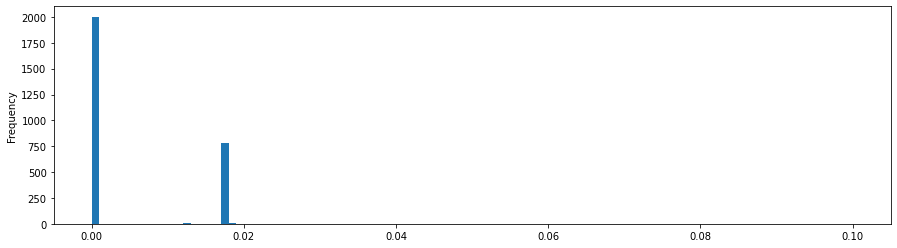

In [33]:
df_text.Line_lower_delta_ratio.plot.hist(bins = 100, figsize = (15, 4), range = [0, 0.1])

In [34]:
# define episode ids as "digits, that are significantly separated form other spans on the y-axis"
df_episode_ids = df_text[(
    (df_text.Text.apply(lambda t: t.strip().isdigit())) & # digit
    (df_text.Line_upper_delta_ratio > 0.01) &             # significantly separated from previous span (>1% of page height)
    (df_text.Line_lower_delta_ratio > 0.01)               # significantly separated from next span (>1% of page height)
)]

In [35]:
df_episode_ids

,Page,Block,Line,Span,Text,Text_reordered,Font,Fontsize,Block_x_left,Block_y_top,...,Span_x_right,Span_y_bottom,Span_x_left_ratio,Span_y_top_ratio,Span_x_right_ratio,Span_y_bottom_ratio,Center_x_ratio,Center_y_ratio,Line_upper_delta_ratio,Line_lower_delta_ratio
610,25,1,0,0,1,1,"Georgia,Bold",15.0,302.299988,71.865112,...,313.508606,88.908569,0.4940,25.0907,0.5123,25.1123,0.50315,25.10150,0.2467,0.0176
638,25,3,0,0,2,2,"Georgia,Bold",15.0,301.299988,474.975128,...,310.696960,492.018585,0.4923,25.5997,0.5077,25.6212,0.50000,25.61045,0.0176,0.0176
653,26,1,0,0,3,3,"Georgia,Bold",15.0,301.299988,71.865112,...,310.667664,88.908569,0.4923,26.0907,0.5076,26.1123,0.49995,26.10150,0.3013,0.0176
669,26,3,0,0,4,4,"Georgia,Bold",15.0,301.100006,287.325104,...,310.841217,304.368561,0.4920,26.3628,0.5079,26.3843,0.49995,26.37355,0.0176,0.0179
691,26,5,0,0,5,5,"Georgia,Bold",15.0,301.500000,553.995117,...,310.486816,571.038574,0.4926,26.6995,0.5073,26.7210,0.49995,26.71025,0.0177,0.0179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5483,168,4,0,0,346,346,"Georgia,Bold",15.0,291.700012,325.325104,...,324.308594,342.368561,0.4766,168.4108,0.5299,168.4323,0.50325,168.42155,0.0177,0.0179
5493,168,6,0,0,347,347,"Georgia,Bold",15.0,292.299988,455.765106,...,323.508606,472.808563,0.4776,168.5755,0.5286,168.5970,0.50310,168.58625,0.0179,0.0176
5511,169,1,0,0,348,348,"Georgia,Bold",15.0,291.500000,71.865112,...,324.508606,88.908569,0.4763,169.0907,0.5302,169.1123,0.50325,169.10150,0.1962,0.0176
5521,169,3,0,0,349,349,"Georgia,Bold",15.0,291.700012,236.325134,...,324.308594,253.368591,0.4766,169.2984,0.5299,169.3199,0.50325,169.30915,0.0177,0.0176


In [36]:
episode_ids = df_episode_ids.Text.apply(lambda t: int(t.strip())).tolist() 

# captured integers are precisely consecutive numbers between 1 and 350
len(episode_ids), episode_ids == list(range(1, len(episode_ids)+1))

(350, True)

In [37]:
episode_ids_row_idx = df_episode_ids.index.tolist()

In [38]:
df_episode_ids = df_text.iloc[episode_ids_row_idx]

In [39]:
df_episode_ids

,Page,Block,Line,Span,Text,Text_reordered,Font,Fontsize,Block_x_left,Block_y_top,...,Span_x_right,Span_y_bottom,Span_x_left_ratio,Span_y_top_ratio,Span_x_right_ratio,Span_y_bottom_ratio,Center_x_ratio,Center_y_ratio,Line_upper_delta_ratio,Line_lower_delta_ratio
610,25,1,0,0,1,1,"Georgia,Bold",15.0,302.299988,71.865112,...,313.508606,88.908569,0.4940,25.0907,0.5123,25.1123,0.50315,25.10150,0.2467,0.0176
638,25,3,0,0,2,2,"Georgia,Bold",15.0,301.299988,474.975128,...,310.696960,492.018585,0.4923,25.5997,0.5077,25.6212,0.50000,25.61045,0.0176,0.0176
653,26,1,0,0,3,3,"Georgia,Bold",15.0,301.299988,71.865112,...,310.667664,88.908569,0.4923,26.0907,0.5076,26.1123,0.49995,26.10150,0.3013,0.0176
669,26,3,0,0,4,4,"Georgia,Bold",15.0,301.100006,287.325104,...,310.841217,304.368561,0.4920,26.3628,0.5079,26.3843,0.49995,26.37355,0.0176,0.0179
691,26,5,0,0,5,5,"Georgia,Bold",15.0,301.500000,553.995117,...,310.486816,571.038574,0.4926,26.6995,0.5073,26.7210,0.49995,26.71025,0.0177,0.0179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5483,168,4,0,0,346,346,"Georgia,Bold",15.0,291.700012,325.325104,...,324.308594,342.368561,0.4766,168.4108,0.5299,168.4323,0.50325,168.42155,0.0177,0.0179
5493,168,6,0,0,347,347,"Georgia,Bold",15.0,292.299988,455.765106,...,323.508606,472.808563,0.4776,168.5755,0.5286,168.5970,0.50310,168.58625,0.0179,0.0176
5511,169,1,0,0,348,348,"Georgia,Bold",15.0,291.500000,71.865112,...,324.508606,88.908569,0.4763,169.0907,0.5302,169.1123,0.50325,169.10150,0.1962,0.0176
5521,169,3,0,0,349,349,"Georgia,Bold",15.0,291.700012,236.325134,...,324.308594,253.368591,0.4766,169.2984,0.5299,169.3199,0.50325,169.30915,0.0177,0.0176


<a id="box_episode_content"></a>

## 2.3 Episode content

[Table of content](#TOC)

From the episode markers we then derive, for each episode:

- Text
- List of character bounding boxes*


Remark: Listing character bounding boxes can help solving an issue inherent to pdf parsing (all non-OCR parsing packages are impacted), where text is provided with misordered characters.

In [40]:
# page = doc[25]  # we want text from this page
# print(page.get_textbox(rect = [0, 0, 600, 600]))

<a id="box_hyperlink"></a>

## 2.4 Hyperlink source and target

[Table of content](#TOC)

Each hyperlink should be described as:

- Page number containing the hyperlink source
- Page number containing the hyperlink target
- Coordinates of the source bounding box of the hyperlink
- Coordinates of the targeted point of the hyperlink


From these descriptors we then derive, for each link:

- Source episode id
- Target episode id
- Character indices, in the source text, that contain the hyperlink source

In [41]:
def parse_hyperlinks(doc):
    links = []
    x = 10
    # for each page, get hyperlinks with :
    # - source page number
    # - target page number
    # - source bounding box coordinates
    # - target point coordinates
    for page_idx, page in enumerate(doc):
        page_links = page.get_links()
        page_links = [
            [page_idx] + list(link['from']) + [link['page']] + list(link['to']) + [page.get_textbox(link["from"] + (-x, -x, x, x))]
            for link in page_links
            if ('page' in link and 'from' in link and 'to' in link)
        ]
        links += page_links
    df_links = pd.DataFrame(links, columns = [
        'Source_page', 'Source_x_left', 'Source_y_top',  'Source_x_right', 'Source_y_bottom',  
        'Target_page', 'Target_x', 'Target_y',
        'Text',
    ])
    return df_links



def find_source_ids(df_links, df_episode_ids):
    def find_source(link, df_episode_ids):
        df = df_episode_ids
        df = df[(df.Page < link.Source_page) | (
                (df.Page == link.Source_page) & 
                (df.Span_y_bottom <= link.Source_y_top)
            )]
        target = df.Text.tolist()[-1]
        return target
    
    return df_links.apply(
        func = lambda link: find_source(link, df_episode_ids),
        axis = 1,
    )



def find_target_ids(df_links, df_episode_ids):
    def find_target(link, df_episode_ids):
        df = df_episode_ids
        df = df[(df.Page > link.Target_page) | (
                (df.Page == link.Target_page) & 
                (df.Span_y_bottom >= link.Target_y)
            )]
        target = df.Text.tolist()[0]
        return target
    
    return df_links.apply(
        func = lambda link: find_target(link, df_episode_ids),
        axis = 1,
    )

In [42]:
df_links = parse_hyperlinks(doc)

In [43]:
source_ids = find_source_ids(df_links, df_episode_ids).apply(int).tolist()
target_ids = find_target_ids(df_links, df_episode_ids).apply(int).tolist()

In [44]:
edges = list(zip(source_ids, target_ids))

In [45]:
edges

[(1, 85),
 (1, 275),
 (1, 141),
 (2, 343),
 (2, 276),
 (3, 196),
 (3, 144),
 (4, 75),
 (4, 175),
 (4, 218),
 (5, 111),
 (6, 183),
 (6, 200),
 (7, 108),
 (7, 25),
 (8, 70),
 (9, 236),
 (9, 292),
 (10, 115),
 (10, 83),
 (11, 139),
 (12, 262),
 (12, 247),
 (13, 307),
 (13, 213),
 (14, 43),
 (14, 106),
 (15, 207),
 (15, 201),
 (15, 35),
 (16, 192),
 (17, 53),
 (17, 274),
 (17, 331),
 (18, 239),
 (18, 114),
 (18, 29),
 (19, 272),
 (19, 119),
 (19, 69),
 (20, 272),
 (21, 189),
 (21, 189),
 (21, 312),
 (22, 181),
 (22, 145),
 (23, 337),
 (23, 151),
 (23, 326),
 (24, 234),
 (24, 184),
 (25, 139),
 (26, 249),
 (27, 250),
 (27, 52),
 (28, 130),
 (28, 147),
 (29, 270),
 (30, 194),
 (30, 261),
 (31, 264),
 (32, 176),
 (32, 340),
 (33, 248),
 (34, 328),
 (35, 207),
 (36, 140),
 (36, 323),
 (37, 289),
 (37, 282),
 (38, 128),
 (38, 347),
 (39, 228),
 (40, 105),
 (41, 174),
 (41, 116),
 (42, 238),
 (42, 157),
 (42, 147),
 (43, 195),
 (43, 106),
 (44, 277),
 (44, 338),
 (45, 180),
 (46, 246),
 (46, 296

In [46]:
# a strange situation : 251 as no source
[e for e in edges if e[1] == 251]

[]

<a id="nlp"></a>

# 3. Text analysis

[Table of content](#TOC)

Necessary elements we need to spot, within the target sentences :

- necessary skill
- necessary object (and sometimes quantities, such as for coins)
- necessary accompanying creature (including human)
- necessary action performed
- necessary visited place

Approach :

Process spacy dependency tree to get predicate -> object pairs, and classify object according to predicate.

TODOs:

- [X] form objects as nominal expressions (only keep maximal spans)
- retain valid predicate - object pairs
- collect alternative description of objects (coreference of object, eg join "ce Bracelet" with "Bracelet d'or")
- include negation polarities (modifier of predicate)
- decompose objects containing logical words (eg "Dicipline A or B -> "Dicipline A" or "Dicipline B")
- classify pairs into [required, discovered, abandoned] * [skill, object, pet, act, place] according to predicate (and object ? and context ?)

<a id="nlp_event"></a>

## 3.1 Detection of events

[Table of content](#TOC)

In [22]:
def find_fight_score_from_text(text):
    scores = [
        # tuple(int(e) for e in m.groups())
        m.groups()
        for m in re.finditer('HABILETÉ[\s:;\.]+([0-9]+)\s+ENDURANCE[\s:;\.]+([0-9]+)', text)
    ]
    return (sum(int(sc[0]) for sc in scores), sum(int(sc[1]) for sc in scores))

In [23]:
# find episode random events
for i in episode_dict:
    for kw in ['table de hasard', 'tentez votre chance']:
        episode_dict[i][kw] = int(kw in episode_dict[i]['text'].lower())

        
# find episode fights
for i in episode_dict:
    episode_dict[i]['fight'] = find_fight_score_from_text(episode_dict[i]['text'])

In [24]:
episode_dict[30]

{'text': "Tous ces gens semblent fatigués et affamés. Ils ont parcouru des dizaines de kilomètres pour fuir leur ville incendiée. Soudain, vous entendez en direction du nord de forts battements d'ailes. « Des Kraans ! Cachez-vous ! » hurlent des voix tout au long du chemin. En face de vous, un chariot transportant des enfants casse un essieu : l'une des roues s'est coincée dans une ornière profonde. Les enfants, saisis de panique, se mettent à hurler. Si vous souhaitez aider ces enfants, rendez-vous au 194. Si vous préférez vous mettre à l'abri des arbres, rendez-vous au 261.",
 'targets': {194: {'span': (498, 501),
   'sentence': 'Si vous souhaitez aider ces enfants, rendez-vous au 194'},
  261: {'span': (568, 571),
   'sentence': "Si vous préférez vous mettre à l'abri des arbres, rendez-vous au 261"}},
 'table de hasard': 0,
 'tentez votre chance': 0,
 'fight': (0, 0)}

In [25]:
randoms = [i for i, v in episode_dict.items() if v['table de hasard']]
print(len(randoms), randoms)

21 [2, 7, 17, 21, 22, 36, 44, 49, 89, 158, 160, 188, 205, 226, 237, 275, 279, 294, 302, 314, 337]


In [26]:
fights = [(i, v['fight']) for i, v in episode_dict.items() if v['fight'] != (0, 0)]
print(len(fights), fights)

21 [(17, (16, 24)), (29, (17, 25)), (34, (17, 25)), (43, (16, 10)), (55, (9, 9)), (63, (11, 10)), (72, (15, 24)), (133, (16, 18)), (169, (16, 16)), (170, (17, 7)), (191, (11, 21)), (208, (15, 13)), (220, (11, 20)), (227, (16, 6)), (229, (16, 25)), (231, (13, 20)), (246, (15, 23)), (255, (20, 30)), (283, (17, 25)), (339, (13, 20)), (342, (18, 26))]


<a id="nlp_element"></a>

## 3.2 Extraction of predicate - object pairs

[Table of content](#TOC)

- Predicates are verbs (infinitive tense included)
- objects are nominal spans, with noun as root, not containing any verb

In [27]:
nlp = spacy.load("fr_dep_news_trf")

In [78]:
fine_name_dev = 'Loup Solitaire 03 - Les Grottes de Kalte.pdf'
fine_name_dev = 'Defis Fantastiques 06 - Le Labyrinthe de la Mort.pdf'
file_path_dev = os.path.join(path_to_pdfs, fine_name_dev)
print(file_path_dev)

# parse raw text
text_dev = parse_pdf_raw_text(file_path_dev)

# find episode markers & text
episode_dict_dev = get_episode_dict(text_dev)

C:\Users\Jb\Desktop\NLP\Funcode - Hero Book\data\pdfs\Defis Fantastiques 06 - Le Labyrinthe de la Mort.pdf


In [135]:
# collect all noun chunks from all target sentences
chunks = []
for i in tqdm.notebook.tqdm(episode_dict_dev):
    for j in episode_dict_dev[i]['targets']:
        s = episode_dict_dev[i]['targets'][j]['sentence']
        doc = nlp(s)
        chunks += [
            (n.root.head.text, n.root.dep_, n.root.text, n.text, s, i, j) 
            for n in doc.noun_chunks
            if (
                n.root.head.pos_ == 'VERB'
                #len(re.sub('[A-Z]', '', n.text)) < len(n.text) # chunk contains a capital letter
                and n.root.dep_.endswith('obj')                # chunk is the object of a verb
            )
        ]
        
df_chunks = pd.DataFrame(chunks, columns = ['Predicate', 'Relation', 'Object_root', 'Object', 'Sentence', 'Source', 'Target'])
df_chunks.insert(0, 'File', fine_name_dev)


# collect all noun chunks from all target sentences
spans = []
for i in tqdm.notebook.tqdm(episode_dict_dev):
    for j in episode_dict_dev[i]['targets']:
        s = episode_dict_dev[i]['targets'][j]['sentence']
        doc = nlp(s)
        for t in doc:
            span = doc[min([w.i for w in t.subtree]): max([w.i for w in t.subtree])+1].text
            if (t.head.pos_ == 'VERB'
                and t.pos_ == 'NOUN'
                and 'VERB' not in [w.pos_ for w in t.subtree]
                # and len(re.sub('[A-Z]', '', chunk)) < len(chunk) # chunk contains a capital letter
               ):
                spans += [(t.head.text, t.dep_, t.text, span, s, i, j)]
        
df_spans = pd.DataFrame(spans, columns = ['Predicate', 'Relation', 'Object_root', 'Object', 'Sentence', 'Source', 'Target'])
df_spans.insert(0, 'File', fine_name_dev)

  0%|          | 0/400 [00:00<?, ?it/s]

C:\Users\Jb\anaconda3\envs\herobook\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


  0%|          | 0/400 [00:00<?, ?it/s]

C:\Users\Jb\anaconda3\envs\herobook\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [136]:
df_chunks.shape, df_spans.shape

((260, 8), (416, 8))

<AxesSubplot:>

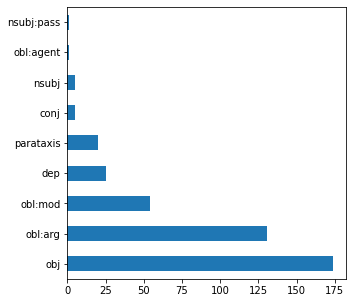

In [137]:
df_spans.Relation.value_counts().plot.barh(figsize = (5, 5))

<AxesSubplot:>

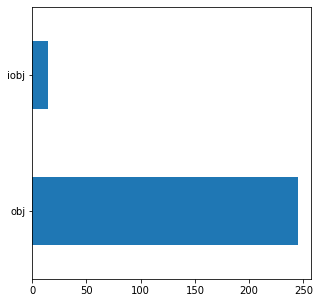

In [138]:
df_chunks.Relation.value_counts().plot.barh(figsize = (5, 5))

<AxesSubplot:>

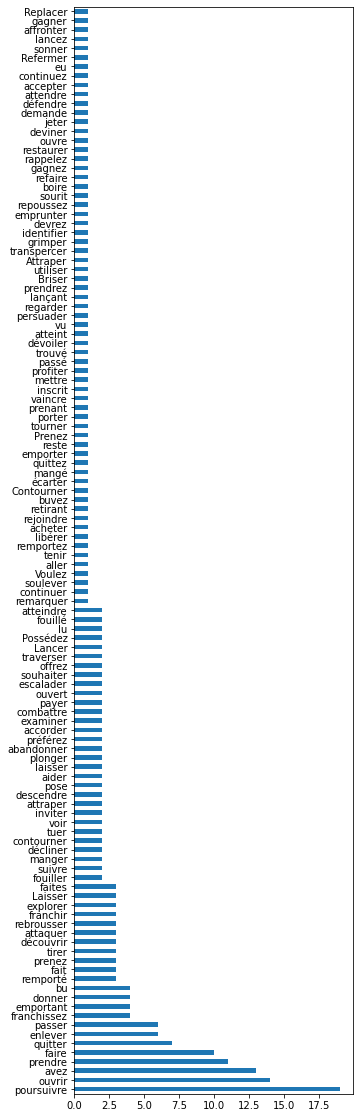

In [139]:
df_chunks.Predicate.value_counts().plot.barh(figsize = (5, 20))

<AxesSubplot:>

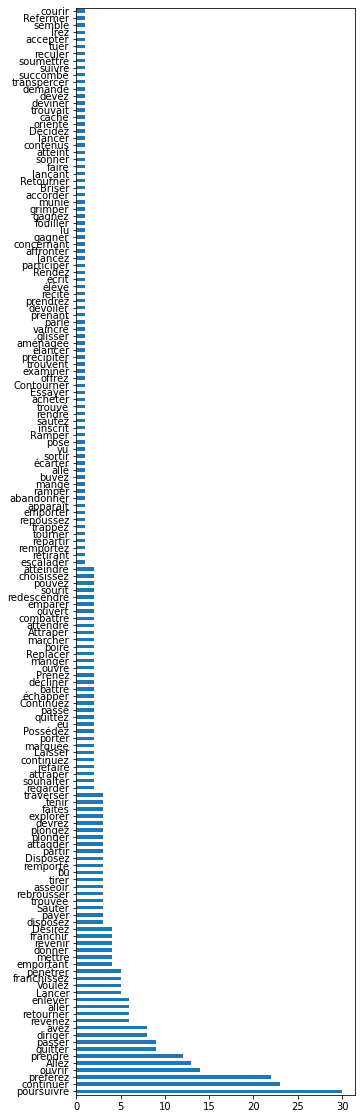

In [125]:
df_spans.Predicate.value_counts().plot.barh(figsize = (5, 20))

In [149]:
df_chunks[df_chunks.Predicate == 'préférez']

,File,Predicate,Relation,Object_root,Object,Sentence,Source,Target
3,Defis Fantastiques 06 - Le Labyrinthe de la Mo...,préférez,obj,rendez-vous,rendez-vous au 66,", ou préférez-vous poursuivre votre chemin en ...",1,66
155,Defis Fantastiques 06 - Le Labyrinthe de la Mo...,préférez,obj,rendez-vous,rendez-vous au 60,", ou préférez-vous aller tout droit vers la vo...",221,60


In [150]:
df_spans[df_spans.Predicate == 'préférez']

,File,Predicate,Relation,Object_root,Object,Sentence,Source,Target
3,Defis Fantastiques 06 - Le Labyrinthe de la Mo...,préférez,obj,rendez-vous,rendez-vous au 66,", ou préférez-vous poursuivre votre chemin en ...",1,66
7,Defis Fantastiques 06 - Le Labyrinthe de la Mo...,préférez,obl:mod,contraire,au contraire,"Si, au contraire, vous préférez redescendre de...",11,46
20,Defis Fantastiques 06 - Le Labyrinthe de la Mo...,préférez,dep,rendez-vous,rendez-vous dans ce cas au 188,", ou préférez-vous continuer vers le nord (ren...",24,188
39,Defis Fantastiques 06 - Le Labyrinthe de la Mo...,préférez,obl:mod,contraire,au contraire,"Si, au contraire, vous préférez revenir au cro...",49,241
51,Defis Fantastiques 06 - Le Labyrinthe de la Mo...,préférez,dep,rendez-vous,rendez-vous dans ce cas au 348,", ou préférez-vous attaquer la Bête Sanguinair...",53,348
58,Defis Fantastiques 06 - Le Labyrinthe de la Mo...,préférez,obl:mod,contraire,au contraire,"Si, au contraire, vous préférez vous mettre à ...",59,283
82,Defis Fantastiques 06 - Le Labyrinthe de la Mo...,préférez,dep,rendez-vous,rendez-vous au 142,", ou préférez-vous poursuivre votre chemin ver...",78,142
84,Defis Fantastiques 06 - Le Labyrinthe de la Mo...,préférez,obl:mod,contraire,au contraire,"Si vous préférez au contraire, essayer de comb...",88,268
116,Defis Fantastiques 06 - Le Labyrinthe de la Mo...,préférez,obl:mod,contraire,au contraire,"Si, au contraire, vous préférez refaire en sen...",117,135
123,Defis Fantastiques 06 - Le Labyrinthe de la Mo...,préférez,parataxis,rendez-vous,rendez-vous au 293,", ou préférez-vous revenir au dernier croiseme...",119,293


In [ ]:
necessary  = ['maîtrisez', 'possédez', 'avez', 'découvert', 'atteint']
lost = ['perdez', 'perdre', ]
act = ['attaquer', 'fouiller', 'combattre', 'poursuivre', 'demander', 'libérer', 'franchir']
gain = ['prendre', 'passer', ]
necessary_visit  = []

#### Apply coreference

In [ ]:
nlp_lg = spacy.load("fr_core_news_lg")
nlp_lg.add_pipe('coreferee')

In [63]:
# doc = nlp(episode_dict_dev[316]['text'])
# doc = nlp('Si vous maîtrisez la Discipline Kaï du Sixième Sens sans avoir le rang de Gardien')
doc = nlp_lg("Si vous avez déjà eu l'occasion de traverser le Cimetière des Anciens, rendez-vous au 77")
doc._.coref_chains.print()
spacy.displacy.render(doc)

0: Cimetière(10), rendez-vous(14)


In [27]:
necessary_skill  = []
necessary_object = []
necessary_pet    = []
necessary_action = []
necessary_visit  = []

In [32]:
episode_dict_dev[316]['text']

"Ce Bracelet dégage une aura de puissance qui vous met mal à l'aise. Les Barbares des Glaces fabriquent leurs armes à l'aide d'os et de dents. Il n'y a en effet aucune mine à Kalte et les métaux y sont considérés comme un bien rare et précieux, tous les métaux, pas seulement l'or. Or, d'après ce que vous savez, lorsque les Barbares des Glaces vont échanger leurs fourrures contre du métal, seul l'acier les intéresse. Ces cruels chasseurs sont tout à fait insensibles à l'art de la joaillerie. Vous en tirez donc la conclusion que ce Bracelet était porté par obligation et non par quelque souci de coquetterie. Vous pouvez prendre ce Bracelet d'Or et le passer à votre poignet ; inscrivez-le alors sur votre Feuille d'Aventure dans la case Objets Spéciaux. Si vous décidez de passer ce Bracelet à votre poignet, rendez-vous au 236. Si vous préférez le laisser là, poursuivez votre chemin le long du couloir en direction du croisement situé plus loin; rendez-vous pour cela au 215."

In [33]:
doc = nlp_lg(episode_dict_dev[316]['text'])
doc._.coref_chains.print()

0: Barbares(16), leurs(20), Barbares(74), leurs(79)
1: mine(38), y(44)
2: métaux(43), métaux(56)
3: fourrures(80), les(88)
4: métal(83), acier(87)
5: chasseurs(93), en(107)
6: Bracelet(114), Bracelet(131), le(135), Bracelet(162), le(174)
7: rendez-vous(167), là(176)


In [34]:
# doc = nlp(episode_dict_dev[316]['text'])
# doc = nlp('Si vous maîtrisez la Discipline Kaï du Sixième Sens sans avoir le rang de Gardien')
doc = nlp_lg('Si vous maîtrisez la Discipline Kaï de la Chasse ou celle de la Communication Animale')
doc._.coref_chains.print()
spacy.displacy.render(doc)

0: Chasse(8), celle(10)


In [35]:
for n in doc.noun_chunks:
    if len(re.sub('[A-Z]', '', n.text))< len(n.text) and n.root.dep_ == 'obj':
        print(list(n.root.ancestors)[0].text, [t.dep_ for t in list(n.root.ancestors)[0].subtree], '|', n.root.dep_, '|', n.root.text, '|',  n.text)

maîtrisez ['mark', 'nsubj', 'ROOT', 'det', 'obj', 'nmod', 'case', 'det', 'nmod', 'cc', 'conj', 'case', 'det', 'nmod', 'amod'] | obj | Discipline | la Discipline Kaï de la Chasse ou celle de la Communication Animale


In [36]:
for t in doc:
    print(t.text, '|', t.pos_, t.morph.to_dict())

Si | SCONJ {}
vous | PRON {'Number': 'Plur', 'Person': '2'}
maîtrisez | VERB {'Mood': 'Ind', 'Number': 'Plur', 'Person': '2', 'Tense': 'Pres', 'VerbForm': 'Fin'}
la | DET {'Definite': 'Def', 'Gender': 'Fem', 'Number': 'Sing', 'PronType': 'Art'}
Discipline | NOUN {'Gender': 'Fem', 'Number': 'Sing'}
Kaï | PROPN {'Gender': 'Masc', 'Number': 'Sing'}
de | ADP {}
la | DET {'Definite': 'Def', 'Gender': 'Fem', 'Number': 'Sing', 'PronType': 'Art'}
Chasse | NOUN {'Gender': 'Fem', 'Number': 'Sing'}
ou | CCONJ {}
celle | PRON {'Gender': 'Fem', 'Number': 'Sing', 'PronType': 'Dem'}
de | ADP {}
la | DET {'Definite': 'Def', 'Gender': 'Fem', 'Number': 'Sing', 'PronType': 'Art'}
Communication | NOUN {'Gender': 'Fem', 'Number': 'Sing'}
Animale | ADJ {'Gender': 'Fem', 'Number': 'Sing'}


## 3.3 Detection of found elements

[Table of content](#TOC)


In [29]:
# nlp = pipeline(
#     task = 'question-answering', 
#     model = 'etalab-ia/camembert-base-squadFR-fquad-piaf', 
#     tokenizer = 'etalab-ia/camembert-base-squadFR-fquad-piaf',
# )

# id_to_object_necessaire = {
#     k: nlp({'question': "Quel objet devez-vous avoir ?", 'context': v['text']})
#     for k, v in episode_dict.items()
# }
# id_to_object_trouve = {
#     k: nlp({'question': "Quel objet trouvez-vous ?", 'context': v['text']})
#     for k, v in episode_dict.items()
# }

<a id="graph"></a>

# 4. Graph representation

[Table of content](#TOC)

See:
- [Graph tutorial](https://networkx.org/documentation/stable/tutorial.html)
- [Graph gallery](https://networkx.org/documentation/stable/auto_examples/index.html)
- [Graph operations](https://networkx.org/documentation/stable/reference/algorithms/index.html)

<a id="graph_construction"></a>

## 4.1 Graph construction

[Table of content](#TOC)

In [84]:
nx_graph = build_nx_graph(episode_dict)

In [85]:
dead_ends = [k for k, v in episode_dict.items() if len(v['targets']) == 0]
len(dead_ends)

17

<a id="graph_visualization"></a>

## 4.2 Graph visualisation

[Table of content](#TOC)

In [86]:
nt_graph = build_nt_graph(episode_dict, height = 1200, width = 1980, notebook = False)

In [87]:
nt_graph.show(os.path.join(path_to_data, 'plots', 'graph.html'))

In [72]:
nx_graph_5 = nx.ego_graph(nx_graph, n = 1, radius = 3)
nt_graph_5 = convert_nx_to_nt_graph(nx_graph_5, node_colors = {1: '#fa624b'}, height = 400, width = 600, notebook = False)

In [73]:
nt_graph_5.show(os.path.join(path_to_data, 'plots', 'graph_5.html'))

<a id="graph_solve"></a>

## 4.3 Solve the book

[Table of content](#TOC)



In [88]:
path = nx.shortest_path(nx_graph, source = 1, target = len(episode_dict))

In [89]:
# solution with text parsing
print(path)

[1, 85, 99, 222, 252, 70, 157, 167, 264, 6, 200, 168, 64, 188, 303, 72, 265, 142, 58, 160, 10, 83, 205, 145, 165, 212, 350]


In [90]:
# 200 : Discipline Kaï du Camouflage
episode_dict[72]

{'text': 'Il vous faut affronter un Glok grimaçant chevauchant sa monture à la gueule hérissée de dents pointues. Vous devez les combattre tous deux en les considérant comme un seul et même adversaire. GLOK+ LOUP MAUDIT HABILETÉ : 15 ENDURANCE : 24 Si vous êtes vainqueur, rendez-vous au 265.',
 'targets': {265: (278, 281)},
 'table de hasard': 0,
 'tentez votre chance': 0,
 'fight': (15, 24)}

In [91]:
w_random = 1000
w_fight  = 10
path_noevent = nx.shortest_path(
    G = nx_graph, 
    source = 1, 
    target = len(episode_dict), 
    weight = lambda s, t, e: (
        w_random * episode_dict[t]['table de hasard'] +
        w_fight * (episode_dict[t]['fight'][0] + episode_dict[t]['fight'][1]) + 1
    ),
)

print(path_noevent)
print(sum([episode_dict[t]['table de hasard'] for t in path_noevent]))
print(sum([episode_dict[t]['fight'][0] for t in path_noevent]))
print(sum([episode_dict[t]['fight'][1] for t in path_noevent]))

[1, 85, 99, 222, 252, 70, 157, 167, 264, 6, 200, 168, 64, 16, 192, 171, 303, 72, 265, 142, 135, 4, 175, 116, 321, 273, 51, 288, 129, 3, 196, 332, 350]
0
15
24


In [92]:
w_random = 100
w_fight  = 100
path_nofight = nx.shortest_path(
    G = nx_graph, 
    source = 1, 
    target = len(episode_dict), 
    weight = lambda s, t, e: (
        w_random * episode_dict[t]['table de hasard'] +
        w_fight * (episode_dict[t]['fight'][0] + episode_dict[t]['fight'][1]) + 1
    ),
)

print(path_nofight)
print(sum([episode_dict[t]['table de hasard'] for t in path_nofight]))
print(sum([episode_dict[t]['fight'][0] for t in path_nofight]))
print(sum([episode_dict[t]['fight'][1] for t in path_nofight]))

[1, 85, 99, 222, 252, 70, 157, 167, 264, 6, 200, 168, 64, 16, 192, 171, 303, 237, 265, 142, 135, 4, 175, 116, 321, 273, 51, 288, 129, 3, 196, 332, 350]
1
0
0


<a id="end_to_end"></a>

# 5. End-to-end process

[Table of content](#TOC)

## 5.1 Le Labyrinthe de la Mort

[Table of content](#TOC)

In [39]:
fine_name_tst = 'Defis Fantastiques 06 - Le Labyrinthe de la Mort.pdf'
file_path_tst = os.path.join(path_to_pdfs, fine_name_tst)
print(file_path_tst)

# parse raw text
text_tst = parse_pdf_raw_text(file_path_tst)

# find episode markers & text
episode_dict_tst = get_episode_dict(text_tst)

C:\Users\Jb\Desktop\NLP\Funcode - Hero Book\data\pdfs\Defis Fantastiques 06 - Le Labyrinthe de la Mort.pdf


In [40]:
# verif
list(episode_dict_tst.keys()) == list(range(1, len(episode_dict_tst.keys())+1))

True

In [41]:
nx_graph_tst = build_nx_graph(episode_dict_tst)
nt_graph_tst = build_nt_graph(episode_dict_tst, height = 1200, width = 1980, notebook = False)
# nt_graph_tst.show(os.path.join(path_to_data, 'plots', 'graph_tst.html'))

In [42]:
path_tst = nx.shortest_path(nx_graph_tst, source = 1, target = len(episode_dict_tst))

print(path_tst)

[1, 66, 293, 387, 114, 298, 279, 32, 37, 239, 344, 107, 267, 68, 271, 237, 100, 87, 381, 128, 35, 124, 81, 136, 78, 142, 338, 282, 22, 63, 194, 369, 288, 221, 60, 179, 191, 152, 55, 143, 163, 302, 379, 213, 108, 59, 283, 109, 43, 316, 241, 291, 90, 172, 278, 134, 247, 364, 31, 376, 62, 177, 243, 400]


In [43]:
w_random = 1000
w_fight  = 10
path_noevent_tst = nx.shortest_path(
    G = nx_graph_tst, 
    source = 1, 
    target = len(episode_dict_tst), 
    weight = lambda s, t, e: (
        w_random * episode_dict_tst[t]['tentez votre chance'] +
        w_fight * (episode_dict_tst[t]['fight'][0] + episode_dict_tst[t]['fight'][1]) + 1
    ),
)

print(path_noevent_tst)
print(sum([episode_dict_tst[t]['tentez votre chance'] for t in path_noevent_tst]))
print(sum([episode_dict_tst[t]['fight'][0] for t in path_noevent_tst]))
print(sum([episode_dict_tst[t]['fight'][1] for t in path_noevent_tst]))

[1, 66, 293, 137, 362, 264, 355, 110, 223, 313, 32, 37, 239, 344, 107, 267, 68, 271, 237, 100, 87, 381, 128, 35, 124, 81, 136, 78, 142, 338, 282, 22, 63, 194, 369, 288, 221, 60, 179, 84, 152, 55, 40, 163, 302, 379, 213, 14, 310, 262, 368, 234, 183, 218, 252, 90, 172, 278, 134, 247, 364, 31, 376, 62, 177, 243, 400]
1
62
62


In [44]:
w_random = 100
w_fight  = 100
path_noevent_tst = nx.shortest_path(
    G = nx_graph_tst, 
    source = 1, 
    target = len(episode_dict_tst), 
    weight = lambda s, t, e: (
        w_random * episode_dict_tst[t]['tentez votre chance'] +
        w_fight * (episode_dict_tst[t]['fight'][0] + episode_dict_tst[t]['fight'][1]) + 1
    ),
)

print(path_noevent_tst)
print(sum([episode_dict_tst[t]['tentez votre chance'] for t in path_noevent_tst]))
print(sum([episode_dict_tst[t]['fight'][0] for t in path_noevent_tst]))
print(sum([episode_dict_tst[t]['fight'][1] for t in path_noevent_tst]))

[1, 66, 293, 137, 362, 264, 355, 110, 223, 313, 32, 37, 239, 344, 107, 267, 68, 271, 237, 100, 87, 381, 128, 35, 124, 81, 136, 78, 142, 338, 282, 22, 63, 194, 369, 288, 221, 60, 179, 84, 152, 55, 40, 163, 302, 379, 213, 14, 310, 262, 368, 234, 183, 218, 252, 90, 357, 180, 53, 370, 104, 134, 247, 364, 31, 376, 62, 177, 243, 400]
2
50
52


Put additional constrains

In [45]:
def shortest_path(graph, source, target, weight = None, include = [], verbose = False):
    perms = list(itertools.permutations(include))
    perms = [[source] + list(p) + [target] for p in perms]
    paths = []
    for perm in perms:
        try:
            path = [source]
            for i in range(len(perm)-1):
                span = nx.shortest_path(graph, source = perm[i], target = perm[i+1], weight = weight)
                path += span[1:]
            paths.append(path)
            if verbose:
                print("Permutation succeeded : {}".format(perm))
            break
        except:
            if verbose:
                print("Permutation failed : {}".format(perm))

    if paths:
        paths.sort(key = len)
        path = paths[0]
    else:
        path = None
    return path

In [46]:
[k for k, v in episode_dict_tst.items() if int('bouclier' in v['text'].lower())]

[68, 95, 196, 217, 222, 271, 380]

In [47]:
w_random = 1000
w_fight  = 10

path_tst = shortest_path(
    graph = nx_graph_tst, 
    source = 1, 
    target = max(nx_graph_tst.nodes()), 
    weight = lambda s, t, e: (
        w_random * episode_dict_tst[t]['tentez votre chance'] +
        w_fight * (episode_dict_tst[t]['fight'][0] + episode_dict_tst[t]['fight'][1]) + 1
    ),
    include = [
        # mandatory
        11,  # émeraude
        162, # saphir
        320, # diamant
        229, # poeme
        212, # conserver le bouclier
        266, # viel os
        
        # helpful
        281, # talisman
        52, # description bete sanguinaire
        5,
        328, 
    ],
    verbose = False,
)

print(path_tst)
print(sum([episode_dict_tst[t]['tentez votre chance'] for t in path_tst]))
print(sum([episode_dict_tst[t]['fight'][0] for t in path_tst]))
print(sum([episode_dict_tst[t]['fight'][1] for t in path_tst]))

[1, 66, 293, 137, 362, 264, 355, 110, 223, 313, 32, 37, 351, 186, 260, 166, 11, 46, 239, 344, 229, 107, 267, 68, 212, 285, 237, 100, 87, 381, 128, 35, 124, 81, 136, 78, 301, 162, 142, 338, 282, 22, 63, 194, 52, 369, 288, 221, 60, 179, 191, 152, 55, 40, 163, 302, 379, 213, 108, 59, 283, 109, 24, 188, 155, 378, 112, 356, 170, 281, 192, 292, 230, 5, 185, 318, 86, 187, 360, 328, 99, 266, 305, 253, 315, 245, 258, 248, 214, 181, 312, 232, 320, 127, 90, 172, 278, 134, 247, 364, 31, 376, 62, 177, 243, 400]
5
100
102


In [48]:
dead_ends_tst = [k for k, v in episode_dict_tst.items() if len(v['targets']) == 0]
len(dead_ends_tst)

33

<a id="bottom"></a>

[Table of content](#TOC)